### Data Source and Attribution

The wealth of different areas data is licensed under the Creative Commons Attribution 4.0 International (CC BY 4.0) licence by the University of Otago.  
It is derived from the NZDep2023 Index of Socioeconomic Deprivation.

The crash data is provided by Waka Kotahi NZ Transport Agency – Crash Analysis System (CAS) under the same CC BY 4.0 International license.

For full license details, see: https://creativecommons.org/licenses/by/4.0/

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [84]:
#Dataset of crashes in New Zealand
file_path = "Datasets/Crash_Analysis_System_(CAS)_data.csv"

# Dataset used to determine wealth of area
area_wealth = pd.read_csv("Datasets/NZDep2023_WgtAvDom-text.txt", sep='\t')

crash_data = pd.read_csv(file_path)
crash_data['crashSeverity'].value_counts()



crashSeverity
Non-Injury Crash    607114
Minor Crash         204552
Serious Crash        50189
Fatal Crash           8031
Name: count, dtype: int64

In [85]:
area_wealth.head()

Domicile_code  AU2017_code                       AU2017_name  \
0              1       500100                            Awanui   
1              2       500202  Karikari Peninsula-Maungataniwha   
2              3       500203                Taipa Bay-Mangonui   
3              4       500204                          Herekino   
4              5       500205                           Ahipara   

   Dom_average_NZDep2023  Dom_average_NZDep2023_score  
0                     10                         1153  
1                      9                         1106  
2                      8                         1050  
3                      9                         1109  
4                      9                         1096

In [86]:
area_wealth.rename(columns={'AU2017_code': 'areaUnitID'}, inplace=True)
df = crash_data.merge(
    area_wealth[['areaUnitID', 'Dom_average_NZDep2023_score','Dom_average_NZDep2023']],
    on='areaUnitID',
    how='inner'
)
df['decile'] = df['Dom_average_NZDep2023']



In [87]:
print(df['decile'].value_counts())

decile
9     116315
5     104902
8     103209
7      92889
4      87963
6      85614
10     85243
3      76632
2      64674
1      52232
Name: count, dtype: int64


## Question 1: is there a correlation between the wealth of an area and the severity of crashes there

In [88]:
severity_counts = (
    df.groupby(['decile', 'crashSeverity'])
      .size()
      .unstack(fill_value=0)
)

severity_props = severity_counts.div(severity_counts.sum(axis=1), axis=0)
ordered = ['Fatal Crash', 'Serious Crash', 'Minor Crash', 'Non-Injury Crash']

# Reindex columns in that order
severity_props = severity_props.reindex(columns=ordered)



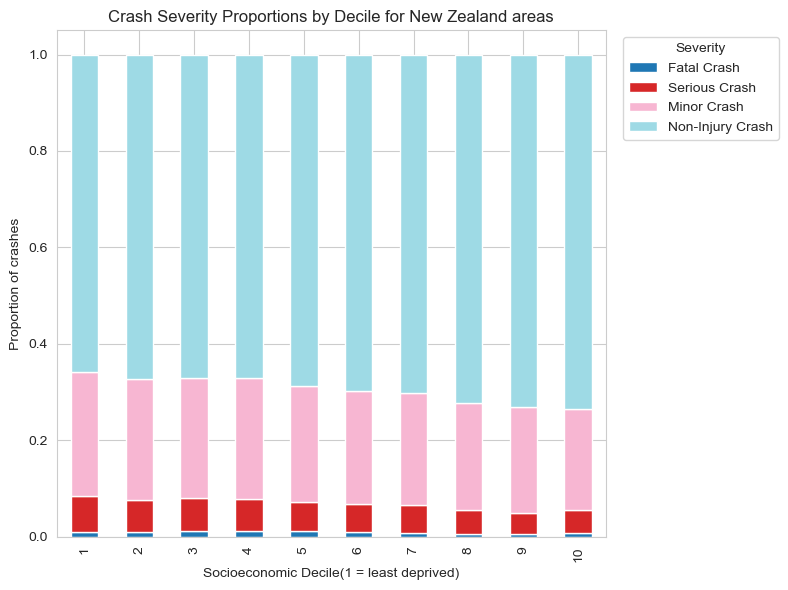

In [105]:
ax = severity_props.plot(
    kind='bar',
    stacked=True,
    figsize=(8,6),
    colormap='tab20'
)
ax.set_xlabel('Socioeconomic Decile(1 = least deprived)')
ax.set_ylabel('Proportion of crashes')
ax.set_title('Crash Severity Proportions by Decile for New Zealand areas')
plt.legend(title='Severity', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

C:\Users\lucas\AppData\Local\Temp\ipykernel_78972\1104347138.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


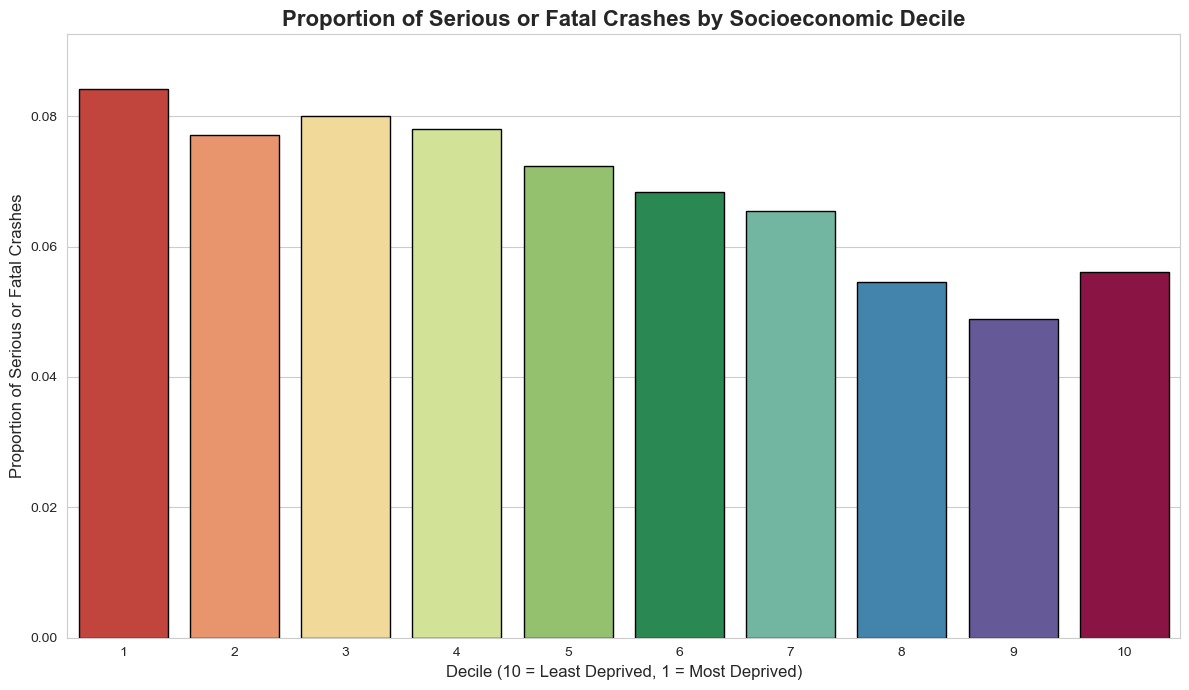

In [90]:
# Calculate total crashes and serious crashes per decile
total_crashes = df_model.groupby('decile').size()
serious_crashes = df_model.groupby('decile')['serious_or_fatal'].sum()

# Calculate proportion (serious crashes / total crashes)
proportion_serious = (serious_crashes / total_crashes).reset_index(name='Proportion Serious or Fatal')

# Reverse decile order for x-axis (10 to 1)
proportion_serious = proportion_serious.sort_values('decile', ascending=False)

# Set figure size and style
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Define bold color palette with reds and contrasting colors
palette = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850', '#66c2a5', '#3288bd', '#5e4fa2', '#9e0142']

# Create bar plot
barplot = sns.barplot(
    data=proportion_serious,
    x='decile',
    y='Proportion Serious or Fatal',
    palette=palette,
    edgecolor='black'
)

# Titles and labels
plt.title('Proportion of Serious or Fatal Crashes by Socioeconomic Decile', fontsize=16, weight='bold')
plt.xlabel('Decile (10 = Least Deprived, 1 = Most Deprived)', fontsize=12)
plt.ylabel('Proportion of Serious or Fatal Crashes', fontsize=12)
plt.ylim(0, proportion_serious['Proportion Serious or Fatal'].max() * 1.1)

plt.tight_layout()
plt.savefig("test.png")
plt.show()



The anwser is that crashes are on average more serious when they happen in less economically privileged regions as evidenced visually

## Question 2: Is this statistically significant


In [117]:
cont_table = pd.crosstab(
    index=df['Dom_average_NZDep2023'],  # Neighborhood deprivation decile (1-10)
    columns=df['crashSeverity']         # Crash severity categories
)

#Perform chi-square test of independence
chi2_stat, p, dof, expected = chi2_contingency(cont_table)

# Handle extreme p-values (prevent underflow)
try:
    p_accurate = chi2.sf(chi2_stat, dof)  # Survival function for small p-values
except FloatingPointError:
    p_accurate = np.nextafter(0, 1)  # Smallest representable positive float

# Report test statistics
print(f"χ²({dof}) = {chi2_stat:.1f}")
if p_accurate < 0.00001:
    print("p-value < 0.00001")  # Cap at 5 decimals
else:
    print(f"p-value = {p_accurate:.5f}")


# 4. Calculate effect size (Cramer's V)
n = cont_table.sum().sum()  # Total cases
cramers_v = np.sqrt(chi2_stat / (n * (min(cont_table.shape) - 1)))
print(f"\n[EFFECT SIZE]\nCramer's V: {cramers_v:.3f}")


χ²(27) = 3420.5
p-value < 0.00001

[EFFECT SIZE]
Cramer's V: 0.036


**Key Finding:**  
The chi-square test reveals an **overwhelming association** between neighborhood deprivation and crash severity:  
- χ²(27) = 3420.5  
- *p* < 0.00001 

### Interpreting the Results  

1. **Certainty of Association**  
   - The near-zero p value suggests this pattern is incredibly unlikely to be random.  

2. **Effect Size Nuance** (Cramer’s V = 0.036)  
   - While statistically significant, the practical impact is modest:  
     - Deprivation explains ~0.1% of severity variance (V² = 0.0013)  
     - Likely reflects **systemic but small-magnitude** disparities    

> **Policy Insight**: While the effect size is small, the statistical certainty suggests deprivation should be considered in safety interventions—especially given the human cost of severe crashes.


In [ ]:
# Collapse crash severities
df['serious_or_fatal'] = df['crashSeverity'].isin(['Fatal Crash', 'Serious Crash'])

# Proportion of serious/fatal per decile
serious_rate_by_decile = (
    df.groupby('Dom_average_NZDep2023')['serious_or_fatal']
      .mean()
      .sort_index()
)


serious_rate_by_decile.plot(kind='bar', figsize=(8,5), color='crimson')
plt.ylabel('Proportion of Serious or Fatal Crashes')
plt.xlabel('NZDep Decile (1 = Least Deprived)')
plt.title('Proportion of Serious/Fatal Crashes by Area Deprivation')
plt.tight_layout()
plt.show()

Severe accidents are generally less likely to result in death in more affluent regions

## Question 3: To what degree could factors such as speed limit, number of cyclists and number of pedestrians be affecting whether a crash is serious or not

In [ ]:
df['speedLimit'].dropna()
df['pedestrian'].fillna(0)
df['bicycle'].fillna(0)


In [ ]:
# Define columns needed for modeling
columns_needed = [
    'crashSeverity',
    'speedLimit',
    'urban',
    'pedestrian',
    'bicycle',
    'decile'
]

# Filter rows and select relevant columns
df_model = df.loc[df['speedLimit'] <= 100, columns_needed].copy()

# Create binary target: 1 if crash is serious or fatal, else 0
df_model['serious_or_fatal'] = df_model['crashSeverity'].isin(['Fatal Crash', 'Serious Crash']).astype(int)

# Bin speedLimit into categorical bins
df_model['speed_bin'] = pd.cut(
    df_model['speedLimit'],
    bins=[0, 50, 80, 100],
    labels=['≤50', '51–80', '81–100'],
    right=True
)

# Normalize urban/rural labels to consistent strings
df_model['urban'] = df_model['urban'].replace({'Rural': 'Rural', 'Open': 'Urban'})

# Fill missing vulnerable user counts with zero, then sum pedestrians and bicycles
df_model['pedestrian'] = df_model['pedestrian'].fillna(0)
df_model['bicycle'] = df_model['bicycle'].fillna(0)
df_model['vulnerable_count'] = df_model['pedestrian'] + df_model['bicycle']

# Specify categorical and numeric feature columns
categorical_cols = ['speed_bin', 'urban']
numeric_cols = ['decile', 'vulnerable_count']

# Prepare feature matrix and target vector
X = df_model[categorical_cols + numeric_cols]
y = df_model['serious_or_fatal']

# Setup preprocessing: One-hot encode categoricals, passthrough numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Build pipeline: preprocessing + logistic regression model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit logistic regression model
pipeline.fit(X, y)

# Map model coefficients back to feature names for interpretation
feature_names = (
    pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_cols)
).tolist() + numeric_cols

coefs = pipeline.named_steps['classifier'].coef_[0]

for feature, coef in zip(feature_names, coefs):
    print(f"{feature}: {coef:.4f}")

### Interpretation of Logistic Regression Results

- **speed_bin_81–100 (Coefficient: 0.5899)**  
  Crashes occurring in the speed limit range 81–100 km/h are associated with higher odds of being serious or fatal compared to the baseline category (speed bin 51–80). The positive coefficient suggests that higher speed limits increase crash severity risk.

- **speed_bin_≤50 (Coefficient: -0.6664)**  
  Crashes in the lowest speed bin (≤50 km/h) have lower odds of being serious or fatal relative to the baseline. This negative coefficient aligns with expectations that lower speeds tend to reduce crash severity.

- **decile (Coefficient: -0.0177)**  
  The decile variable, representing socio-economic deprivation (where higher decile indicates less deprivation), shows a slight negative association with crash severity. This implies crashes in less deprived areas tend to be slightly less severe, though the effect size is small.

- **vulnerable_count (Coefficient: 1.8281)**  
  The count of vulnerable road users (pedestrians and bicyclists) involved in crashes has a strong positive association with severity, indicating that their involvement greatly increases the likelihood of serious or fatal outcomes.

## Question 4: Are the other factors also affected by the wealth of the area

In [ ]:
#Using vulnerables as a test/example
df['vulnerable_count'] = df['pedestrian'].fillna(0) + df['bicycle'].fillna(0)

subset = df[['Dom_average_NZDep2023', 'vulnerable_count']].dropna()

count_table = pd.crosstab(subset['Dom_average_NZDep2023'], subset['vulnerable_count'])

chi2, p, dof, expected = chi2_contingency(count_table)

print(f"\nChi² = {chi2:.2f}, p = {p:.5f}, dof = {dof}")


As evidence by the incredibly low p-value, there is also a strong connection between the other factors and the wealth of the area. 
To completely understand how the different variables interact with each other significant further modelling would be done

## Conclusion

This analysis demonstrates a clear correlation between socioeconomic deprivation and crash severity in New Zealand. Crashes occurring in less economically privileged areas tend to be more serious, a relationship that is statistically significant given the very low p-values observed.

Additionally, factors such as speed limit categories and vulnerable user involvement (pedestrians and cyclists) play a meaningful role in determining the likelihood of a crash being serious or fatal which could also be . For example, higher speed limits and greater vulnerable user presence increase the odds of severe crashes.

Overall, these findings highlight the importance of considering socioeconomic context alongside traffic and environmental factors when developing road safety interventions. They also show that many factors interact with each other complicating the data significantly. Another way for possible improvement could be in the data collection. If data collection showed when crashes happened with poor lighting(focusing on manmade) or ambulance response times it could show specific areas for change.
